In [1]:
import os
import math
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

In [2]:
os.chdir('/Users/quan/Downloads/PythonBook_code_data/part4/025')

In [3]:
# 2001年1月 到 2014年2月 中國大陸月度CPI
CPI=pd.read_csv('/Users/quan/Downloads/PythonBook_code_data/part4/025/CPI.csv',index_col='time')
#轉換成時間序列格式
CPI.index=pd.to_datetime(CPI.index)
CPI.shape

(161, 1)

In [4]:
CPI.head(n=3)

,CPI
time,
2014-05-01,100.1
2014-04-01,99.7
2014-03-01,99.5


In [5]:
#序列後三個做為預測對照
CPI.tail(n=3)

,CPI
time,
2001-03-01,99.4
2001-02-01,100.2
2001-01-01,101.9


In [6]:
CPI=CPI.sort_index() #按日期排序
#選擇train data
CPItrain=CPI[:-3]
CPItrain.tail(n=3)

,CPI
time,
2013-12-01,100.3
2014-01-01,101.0
2014-02-01,100.5


In [7]:
#選擇test data
CPItest = CPI[-3:]
CPItest

,CPI
time,
2014-03-01,99.5
2014-04-01,99.7
2014-05-01,100.1


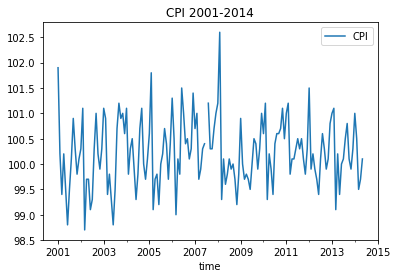

In [9]:
#繪製時序圖
CPI.plot(title='CPI 2001-2014')

定態，未明顯遞增遞減

In [12]:
# 對序列進行ADF單根檢定，判斷其定態性
# 載ADF函數
from arch.unitroot import ADF

In [13]:
#進行ADF單根檢定，並檢視結果
#最大落後階數設為10
#防止使用的落後階數過多導致p=value偏低

CPItrain=CPItrain.dropna()
print(ADF(CPItrain,max_lags=10).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.947
P-value                         0.040
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


統計量等於-2.947，小於5%顯著性水平下的臨界值-2.88，拒絕虛無假設，序列為定態 

判斷CPI序列是否為白雜訊序列，採LB檢定(Ljung-Box)

Ljung-Box 採用Q統計量

In [15]:
from statsmodels.tsa import stattools
LjungBox=stattools.q_stat(stattools.acf(CPItrain)[1:12],len(CPItrain))
LjungBox[1][-1] 

0.0005560128948515358

檢定的p值為0.000556<0.05，拒絕虛無假設，接受對立假設，認為CPI序列不是白雜訊序列。

2.模型識別與估計

採ARMA模型，識別參數p和q，利用ACF和PACF來判斷模型的具體形式。

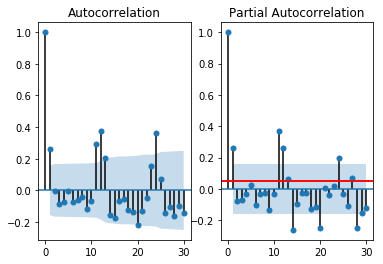

In [67]:
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
#將畫面一分為二
axe1=plt.subplot(121)
axe2=plt.subplot(122)

#在第一個畫面中畫出序列的自相關係數圖 
plot1=plot_acf(CPItrain,lags=30,ax=axe1),plt.axhline(0.05, color= 'r')

#在第二個畫面中畫出序列的偏自相關係數圖
plot2=plot_pacf(CPItrain,lags=30,ax=axe2),plt.axhline(0.05, color= 'r')

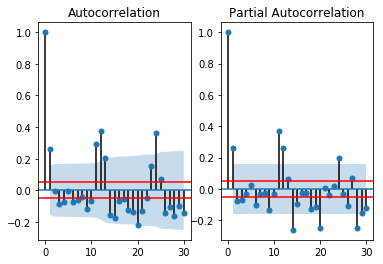

In [79]:
axe1=plt.subplot(121)
#在第一個畫面中畫出序列的自相關係數圖 
plot1=plot_acf(CPItrain,lags=30,ax=axe1),plt.axhline(0.05, color= 'r'),plt.axhline(-0.05, color= 'r')
axe2=plt.subplot(122)
plot2=plot_pacf(CPItrain,lags=30,ax=axe2),plt.axhline(0.05, color= 'r'),plt.axhline(-0.05, color= 'r')

CPItrain的自相關和偏自相關係數圖

透過CPI訓練集序列的ACF和PACF圖，我們發現序列的自相關係數和偏自相關係數都呈現出拖尾的性質，因此可以初步判斷 p>0 , q>0。至於p和q的具體取值還無法判斷。因此考慮建立起低階p、q的各種組合情況下的ARMA模型，並運用AIC準則比較，選出AIC最小的模型。

In [17]:
from statsmodels.tsa import arima_model
#order表示建立的模型的階數，c(1,0,1)表示建立的是ARMA(1,1)模型；
#中間的數字0表示使用原始的、未進行過差分（差分次數為0）的數據；
#此處我們無需考慮它

model1=arima_model.ARIMA(CPItrain,order=(1,0,1)).fit()
model1.summary()

/Users/quan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(1, 1)   Log Likelihood                -150.339
Method:                       css-mle   S.D. of innovations              0.630
Date:                Mon, 16 Mar 2020   AIC                            308.678
Time:                        15:54:35   BIC                            320.903
Sample:                             0   HQIC                           313.643
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2373      0.066   1516.140      0.000     100.108     100.367
ar.L1.CPI      0.0934      0.248      0.377      0.707      -0.392       0.579
ma.L1.CPI      0.1932      0.240      0.805      0.422      -0.277       0.664
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.7069           +0.0000j           10.7069            0.0000
MA.1           -5.1771           +0.0000j            5.1771            0.5000
-----------------------------------------------------------------------------
"""

In [18]:
#同理，我們建立起其它階數的模型
model2=arima_model.ARIMA(CPItrain,order=(1,0,2)).fit()
model2.summary()

/Users/quan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(1, 2)   Log Likelihood                -150.261
Method:                       css-mle   S.D. of innovations              0.630
Date:                Mon, 16 Mar 2020   AIC                            310.521
Time:                        15:54:42   BIC                            325.802
Sample:                             0   HQIC                           316.727
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2375      0.067   1502.409      0.000     100.107     100.368
ar.L1.CPI     -0.2048      0.673     -0.304      0.761      -1.523       1.114
ma.L1.CPI      0.4956      0.667      0.743      0.459      -0.811       1.802
ma.L2.CPI      0.1054      0.199      0.531      0.596      -0.284       0.495
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.8834           +0.0000j            4.8834            0.5000
MA.1           -2.3501           -1.9904j            3.0797           -0.3882
MA.2           -2.3501           +1.9904j            3.0797            0.3882
-----------------------------------------------------------------------------
"""

In [19]:
model3=arima_model.ARIMA(CPItrain,order=(2,0,1)).fit()
model3.summary()

/Users/quan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(2, 1)   Log Likelihood                -148.966
Method:                       css-mle   S.D. of innovations              0.621
Date:                Mon, 16 Mar 2020   AIC                            307.933
Time:                        15:55:07   BIC                            323.214
Sample:                             0   HQIC                           314.139
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2517      0.018   5622.142      0.000     100.217     100.287
ar.L1.CPI      1.2533      0.077     16.224      0.000       1.102       1.405
ar.L2.CPI     -0.3025      0.080     -3.802      0.000      -0.458      -0.147
ma.L1.CPI     -1.0000      0.020    -50.179      0.000      -1.039      -0.961
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0789           +0.0000j            1.0789            0.0000
AR.2            3.0637           +0.0000j            3.0637            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
model4=arima_model.ARIMA(CPItrain,order=(2,0,2)).fit()
model4.summary()


/Users/quan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(2, 2)   Log Likelihood                -148.635
Method:                       css-mle   S.D. of innovations              0.623
Date:                Mon, 16 Mar 2020   AIC                            309.271
Time:                        15:55:12   BIC                            327.608
Sample:                             0   HQIC                           316.718
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2357      0.059   1699.235      0.000     100.120     100.351
ar.L1.CPI     -0.2014      0.196     -1.025      0.307      -0.586       0.184
ar.L2.CPI     -0.6594      0.134     -4.918      0.000      -0.922      -0.397
ma.L1.CPI      0.4404      0.164      2.680      0.008       0.118       0.762
ma.L2.CPI      0.7684      0.143      5.357      0.000       0.487       1.050
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1527           -1.2219j            1.2314           -0.2698
AR.2           -0.1527           +1.2219j            1.2314            0.2698
MA.1           -0.2866           -1.1042j            1.1408           -0.2904
MA.2           -0.2866           +1.1042j            1.1408            0.2904
-----------------------------------------------------------------------------
"""

In [21]:
model5=arima_model.ARIMA(CPItrain,order=(3,0,2)).fit()
model5.summary()

/Users/quan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/quan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  157
Model:                     ARMA(3, 2)   Log Likelihood                -147.248
Method:                       css-mle   S.D. of innovations              0.611
Date:                Mon, 16 Mar 2020   AIC                            308.496
Time:                        15:55:19   BIC                            329.889
Sample:                             0   HQIC                           317.184
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.2512      0.018   5467.956      0.000     100.215     100.287
ar.L1.CPI      0.2940      0.078      3.754      0.000       0.141       0.448
ar.L2.CPI      0.8724      0.046     18.999      0.000       0.782       0.962
ar.L3.CPI     -0.2595      0.081     -3.188      0.002      -0.419      -0.100
ma.L1.CPI   7.656e-09      0.029   2.66e-07      1.000      -0.056       0.056
ma.L2.CPI     -1.0000      0.029    -34.730      0.000      -1.056      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0692           +0.0000j            1.0692            0.5000
AR.2            1.0735           +0.0000j            1.0735            0.0000
AR.3            3.3576           +0.0000j            3.3576            0.0000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [23]:
ABICpq = [{"(p,q)":'(1,1)',"模型":"mod1", "AIC值":308.678, "BIC值":320.903},
          {"(p,q)":'(1,2)',"模型":"mod2", "AIC值":310.521, "BIC值":325.802},
          {"(p,q)":'(2,1)',"模型":"mod3", "AIC值":307.933, "BIC值":323.214},
         {"(p,q)":'(2,2)',"模型":"mod4", "AIC值":309.271, "BIC值":327.608},
         {"(p,q)":'(3,1)',"模型":"mod5", "AIC值":308.496, "BIC值":317.184}]
ABICpq_df = pd.DataFrame(ABICpq)

In [24]:
ABICpq_df

,"(p,q)",AIC值,BIC值,模型
0,"(1,1)",308.678,320.903,mod1
1,"(1,2)",310.521,325.802,mod2
2,"(2,1)",307.933,323.214,mod3
3,"(2,2)",309.271,327.608,mod4
4,"(3,1)",308.496,317.184,mod5


ARMA(2,1)的AIC值為最小，故模型確定為ARMA(2,1)

3.模型診斷

對模型進行評價係數顯著性的檢定，殘差序列是否為白雜訊的檢定。
如果殘差序列是白雜訊，則說明模型已充分提取序列的資訊。我們無法再透過調整模型從資料中抓取更多的資訊，因而模型的建立是成功的。
如果殘差序列非白雜訊，則說明模型不完善且須對其進行修正。

In [25]:
#計算模型中係數的信賴區間
model3.conf_int()

,0,1
const,100.216756,100.286655
ar.L1.CPI,1.101874,1.404685
ar.L2.CPI,-0.458491,-0.146583
ma.L1.CPI,-1.039059,-0.960941


可以看到所有係數的信賴區間都不包含0，因此我們可以說在5%的信心水準下，
所有係數都是顯著的。

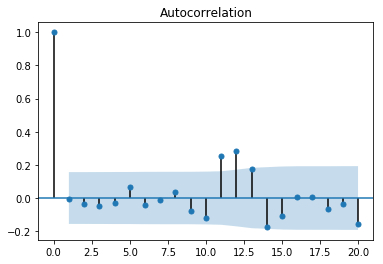

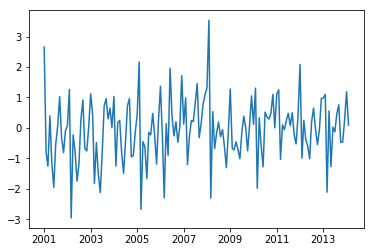

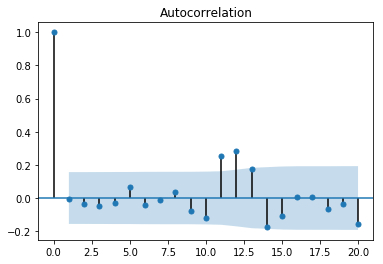

In [26]:
#對殘差序列的純隨機性的檢定
#繪製時間序列模擬的診斷圖
stdresid=model3.resid/math.sqrt(model3.sigma2)
plt.plot(stdresid)
plot_acf(stdresid,lags=20)

In [31]:
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:13],len(stdresid))
LjungBox[1][-1]

0.002646932175117789

In [32]:
#增加Ljung-Box檢定的落後階數
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:20],len(stdresid))
LjungBox[1][-1]

0.0008835831410398088

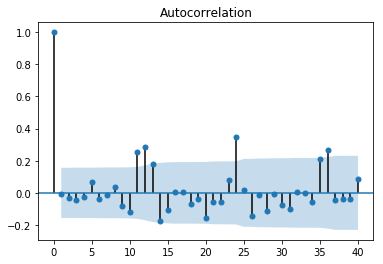

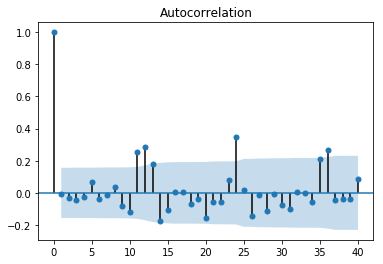

In [33]:
#繪製最大落後階數為40的自相關係數圖
plot_acf(stdresid,lags=40)

殘差基本上在+-3之間，沒有偏差值。但是在ACF圖中，第11階和第12階的字將關係數是顯著的。
因此，無法確定殘差是白雜訊序列。因此增加Ljung-Box檢定的落後階數。

在12階之後，檢定的p值都小於5%。因此模型的殘差並不是一個白雜訊序列。
如果將自相關係數圖的最大落後階數設為40，可以明顯地看到每隔12階自相關係數就會變得顯著。結果表明模型並沒有很好的擬合原資料，需要一個季節性ARIMA模型。

4.運用模型進行預測

用forcast()函數基於以上估計的模型對未來的序列值進行預測。

In [34]:
#用model3 預測未來3期的CPI
model3.forecast(3)[0]

array([100.27850924, 100.21017984, 100.19155315])

透過程式碼可得知，2014年3月4月5月的月度CPI預測值分別為
100.27850928, 100.21017991, 100.19155321。
為了比較預測結果，我們可以檢視原資料集中2014年3月4月5月的月度環比CPI的實際值。

In [35]:
CPI.head(3)
CPItest

,CPI
time,
2014-03-01,99.5
2014-04-01,99.7
2014-05-01,100.1
